<a href="https://colab.research.google.com/github/gourabdatta2384/Python_basics_191-15-2384/blob/main/NashNetLarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Libraries

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 38.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=b288784e8112b9dc1e247ae1f7a785163aa6f868b6c859a19d1d5e212da45705
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LIBRARIES

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Data Preprocessing

In [ ]:
labels = ['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS','LUNGCANCER']

In [ ]:
X_full = []
y_full = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DefenseE/defense dataset/all clean',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 93/93 [02:03<00:00,  1.33s/it]


# Dividing the dataset as a Train & Test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.2,random_state=101)

# Performing One Hot Encoding on the labels after converting it into numerical values

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# ResNet50

In [ ]:
ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
ResNet50.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
  ResNet50,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'),
])

# Compiling the Model

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 126,876,549
Trainable params: 103,288,837


In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',verbose=1)

# Training the Model

In [ ]:
hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1,
                 #epochs =15
                 epochs =30,
                 verbose=1,
                 batch_size=32,
                 #batch_size=16,
                 callbacks=[tensorboard,checkpoint,reduce_lr]
                 )

Epoch 1/30
163/163 [==============================] - ETA: 0s - loss: 2.6333 - accuracy: 0.8923
Epoch 1: val_accuracy improved from -inf to 0.95675, saving model to CovidModelEfficientNet.h5
163/163 [==============================] - 39s 167ms/step - loss: 2.6333 - accuracy: 0.8923 - val_loss: 0.2068 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9542
Epoch 2: val_accuracy did not improve from 0.95675
163/163 [==============================] - 19s 118ms/step - loss: 0.2183 - accuracy: 0.9542 - val_loss: 0.1794 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9606
Epoch 3: val_accuracy improved from 0.95675 to 0.96540, saving model to CovidModelEfficientNet.h5
163/163 [==============================] - 25s 155ms/step - loss: 0.1313 - accuracy: 0.9606 - val_loss: 0.1644 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 4/30
163/163 [=======

# Accuracy of the Model

In [ ]:
results = model.evaluate(X_train,y_train)

181/181 [==============================] - 18s 100ms/step - loss: 0.0165 - accuracy: 0.9967


In [ ]:
results2 = model.evaluate(X_test,y_test)

46/46 [==============================] - 5s 104ms/step - loss: 0.1194 - accuracy: 0.9765


# Visualize of the Graph

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


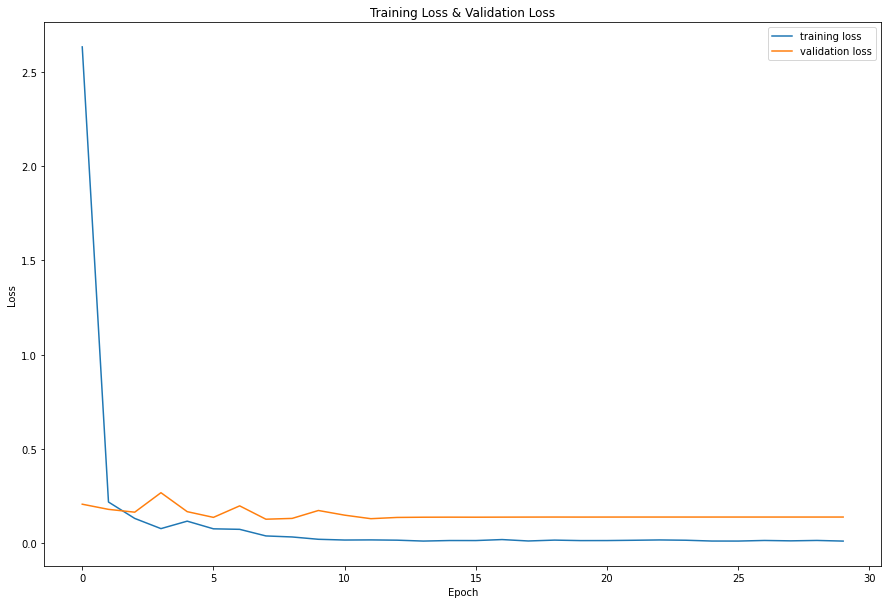

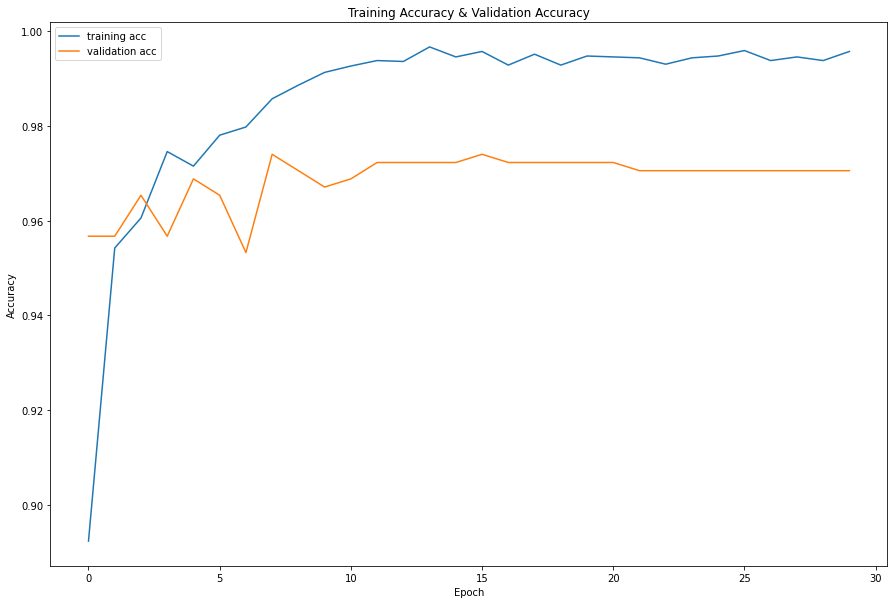

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Visualize of the Graph

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

46/46 [==============================] - 5s 94ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.96      0.95      0.96       315
           2       0.98      0.98      0.98       859
           3       0.99      1.00      1.00       146
           4       0.92      1.00      0.96        11

    accuracy                           0.98      1445
   macro avg       0.97      0.98      0.97      1445
weighted avg       0.98      0.98      0.98      1445



# CONFUSION MATRIX

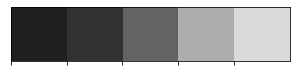

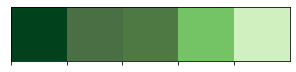

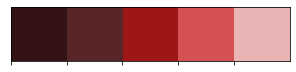

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

[[110   0   2   1   1]
 [  0 298  17   0   0]
 [  2  11 846   0   0]
 [  0   0   0 146   0]
 [  0   0   0   0  11]]


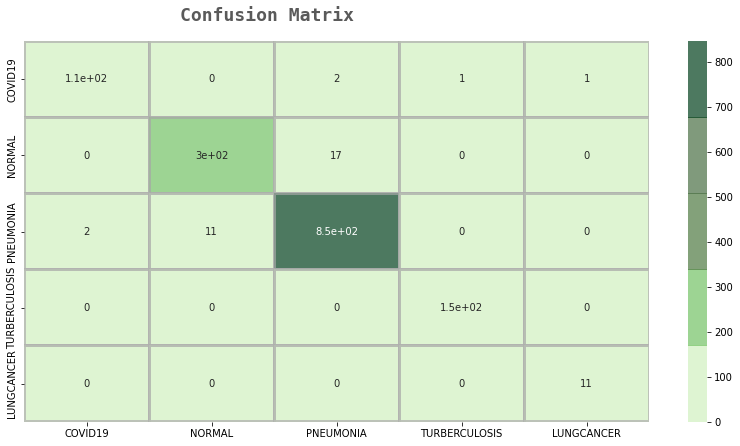

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3]
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()